In [1]:
import numpy as np
import pandas as pd
from glob import glob
import pickle
import re
import matplotlib

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Progress tracker from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

# Building sequences

In [4]:
def build_sequences(csv_files_mask, site_index):
    files = glob(csv_files_mask)
    seq_user_dic = {}
    for userfile in log_progress(files, every=1):
        user = int(re.search('user(\d+)\.csv', userfile).group(1))
        data = pd.read_csv(userfile, \
                           parse_dates=[0], infer_datetime_format=True)
        data.sort_values("timestamp", inplace=True)
        data.reset_index(drop=True, inplace=True)
        
        data["siteid"] = data.site.apply(lambda x: site_index[x])
        
        session = data["siteid"].as_matrix()
        
        ses_seq_set = set() 
        
        it = np.nditer(session, flags=['f_index'])
        while not it.finished:
            #ses_seq_set.add(tuple([str(it[0])]))
            asession = session[it.index+1:it.index+10].copy()
            if len(asession) > 0:      
                ita = np.nditer(asession, flags=['f_index'])
                while not ita.finished:
                    ses_seq_set.add(tuple([str(it[0]), str(ita[0])]))
                    bsession = asession[ita.index+1:ita.index+9]
                    if len(bsession) > 0:
                        itb = np.nditer(bsession, flags=['f_index'])
                        while not itb.finished:
                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0])]))
                            csession = bsession[itb.index+1:itb.index+8]
                            if len(csession) > 0:
                                itc = np.nditer(csession, flags=['f_index'])
                                while not itc.finished:
                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0])]))
                                    dsession = csession[itc.index+1:itc.index+7]
                                    if len(dsession) > 0:
                                        itd = np.nditer(dsession, flags=['f_index'])
                                        while not itd.finished:
                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0])]))
                                            esession = dsession[itd.index+1:itd.index+6]
                                            if len(esession) > 0:
                                                ite = np.nditer(esession, flags=['f_index'])
                                                while not ite.finished:
                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0])]))
                                                    fsession = esession[ite.index+1:ite.index+5]
                                                    if len(fsession) > 0:
                                                        itf = np.nditer(fsession, flags=['f_index'])
                                                        while not itf.finished:
                                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0])]))
                                                            gsession = fsession[itf.index+1:itf.index+4]
                                                            if len(gsession) > 0:
                                                                itg = np.nditer(gsession, flags=['f_index'])
                                                                while not itg.finished:
                                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0]), str(itg[0])]))
                                                                    itg.iternext()
                                                            itf.iternext()
                                                    ite.iternext()
                                            itd.iternext()
                                    itc.iternext()
                            itb.iternext()
                    ita.iternext()
                    
            if (it.index + 1) % 10 == 0:
                for seq in ses_seq_set:         
                    if seq in seq_user_dic:
                        if user in seq_user_dic[seq]:
                            seq_user_dic[seq][user] +=1
                        else:
                            seq_user_dic[seq][user] = 1
                    else:
                        seq_user_dic[seq] = {user: 1}
                ses_seq_set = set()
            it.iternext()
        
        for seq in ses_seq_set:         
            if seq in seq_user_dic:
                if user in seq_user_dic[seq]:
                    seq_user_dic[seq][user] +=1
                else:
                    seq_user_dic[seq][user] = 1
            else:
                seq_user_dic[seq] = {user: 1}        
        
        for seq, users in seq_user_dic.items():
            if len(users) == 1 and users[users.keys()[0]] < 3:
                del seq_user_dic[seq]
        
    return seq_user_dic

In [5]:
def amend_sequences(csv_files_mask, site_index, seq_user_dic):
    files = glob(csv_files_mask)
    newly_added = {}
    for userfile in log_progress(files, every=1):
        user = int(re.search('user(\d+)\.csv', userfile).group(1))
        newly_added[user] = set()
        data = pd.read_csv(userfile, \
                           parse_dates=[0], infer_datetime_format=True)
        data.sort_values("timestamp", inplace=True)
        data.reset_index(drop=True, inplace=True)
        
        data["siteid"] = data.site.apply(lambda x: site_index[x])
        
        session = data["siteid"].as_matrix()
        
        ses_seq_set = set() 
        
        it = np.nditer(session, flags=['f_index'])
        while not it.finished:
            #ses_seq_set.add(tuple([str(it[0])]))
            asession = session[it.index+1:it.index+10].copy()
            if len(asession) > 0:      
                ita = np.nditer(asession, flags=['f_index'])
                while not ita.finished:
                    ses_seq_set.add(tuple([str(it[0]), str(ita[0])]))
                    bsession = asession[ita.index+1:ita.index+9]
                    if len(bsession) > 0:
                        itb = np.nditer(bsession, flags=['f_index'])
                        while not itb.finished:
                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0])]))
                            csession = bsession[itb.index+1:itb.index+8]
                            if len(csession) > 0:
                                itc = np.nditer(csession, flags=['f_index'])
                                while not itc.finished:
                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0])]))
                                    dsession = csession[itc.index+1:itc.index+7]
                                    if len(dsession) > 0:
                                        itd = np.nditer(dsession, flags=['f_index'])
                                        while not itd.finished:
                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0])]))
                                            esession = dsession[itd.index+1:itd.index+6]
                                            if len(esession) > 0:
                                                ite = np.nditer(esession, flags=['f_index'])
                                                while not ite.finished:
                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0])]))
                                                    fsession = esession[ite.index+1:ite.index+5]
                                                    if len(fsession) > 0:
                                                        itf = np.nditer(fsession, flags=['f_index'])
                                                        while not itf.finished:
                                                            ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0])]))
                                                            gsession = fsession[itf.index+1:itf.index+4]
                                                            if len(gsession) > 0:
                                                                itg = np.nditer(gsession, flags=['f_index'])
                                                                while not itg.finished:
                                                                    ses_seq_set.add(tuple([str(it[0]), str(ita[0]), str(itb[0]), str(itc[0]), str(itd[0]), str(ite[0]), str(itf[0]), str(itg[0])]))
                                                                    itg.iternext()
                                                            itf.iternext()
                                                    ite.iternext()
                                            itd.iternext()
                                    itc.iternext()
                            itb.iternext()
                    ita.iternext()
                    
            if (it.index + 1) % 10 == 0:
                for seq in ses_seq_set:         
                    if seq in seq_user_dic:
                        if user in seq_user_dic[seq]:
                            if seq in newly_added[user]:
                                seq_user_dic[seq][user] +=1
                        else:
                            seq_user_dic[seq][user] = 1
                            newly_added[user].add(seq)
                ses_seq_set = set()
            it.iternext()
        
        for seq in ses_seq_set:         
            if seq in seq_user_dic:
                if user in seq_user_dic[seq]:
                    if seq in newly_added[user]:
                        seq_user_dic[seq][user] +=1
                else:
                    seq_user_dic[seq][user] = 1
                    newly_added[user].add(seq) 
        
    return seq_user_dic

In [9]:
with open("site_dic.pkl") as pkl:
    site_dic = pickle.load(pkl)

In [5]:
%%time
seq_user_dic = build_sequences('train/*', site_dic)

CPU times: user 4h 29min 33s, sys: 29.8 s, total: 4h 30min 3s
Wall time: 4h 29min 48s


In [24]:
%%time
seq_user_dic = amend_sequences('train/*', site_dic, seq_user_dic)

CPU times: user 6.58 s, sys: 212 ms, total: 6.79 s
Wall time: 6.39 s


In [ ]:
del seq_user_dic[('11', '7')]

In [30]:
%%time
# Save generated seq_user_dic
with open("seq_user_dic.pkl", 'wb') as pkl:
    pickle.dump(seq_user_dic, pkl)

CPU times: user 4min 37s, sys: 6.14 s, total: 4min 43s
Wall time: 4min 44s


### Load seq_user_dic instead of generating

In [6]:
%%time
# Load seq_user_dic instead of generating
with open("seq_user_dic.pkl", 'rb') as pkl:
    seq_user_dic = pickle.load(pkl)

CPU times: user 4min 33s, sys: 6.42 s, total: 4min 40s
Wall time: 4min 40s


In [7]:
max([len(v) for k, v in seq_user_dic.items()])

398

In [25]:
[[k, v] for k, v in seq_user_dic.items() if len(k) > 7]

[[('183', '186', '186', '186', '183', '186', '183', '88'), {70: 4}],
 [('7', '11', '1713', '1665', '1665', '1665', '1665', '5073'), {454: 3}],
 [('925', '1240', '1346', '1345', '1240', '1344', '1345', '1344'), {813: 4}],
 [('21227', '21226', '21226', '21226', '21227', '21226', '21227', '11'),
  {558: 3}],
 [('1958', '2030', '1958', '2030', '2030', '1958', '2030', '1958'), {788: 5}],
 [('1910', '811', '1910', '27', '793', '793', '793', '1910'),
  {441: 1, 949: 3}],
 [('7649', '7653', '7649', '7655', '7653', '7649', '7653', '7653'), {677: 3}],
 [('179', '178', '186', '186', '183', '186', '186', '186'), {361: 3}],
 [('60', '8107', '60', '8107', '60', '8107', '8079', '60'), {149: 5}],
 [('11', '15397', '11', '7', '15397', '11', '15397', '11'), {368: 8}],
 [('217', '217', '178', '217', '183', '217', '217', '183'),
  {68: 6,
   216: 1,
   361: 1,
   575: 3,
   598: 1,
   706: 1,
   811: 1,
   831: 1,
   909: 1,
   912: 4,
   917: 3,
   949: 1}],
 [('118', '118', '118', '118', '118', '21838',

In [31]:
[[k, v] for k, v in site_dic.items() if v == 25374]

[[u'ws2.smartp.com', 25374]]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa421354690>]], dtype=object)

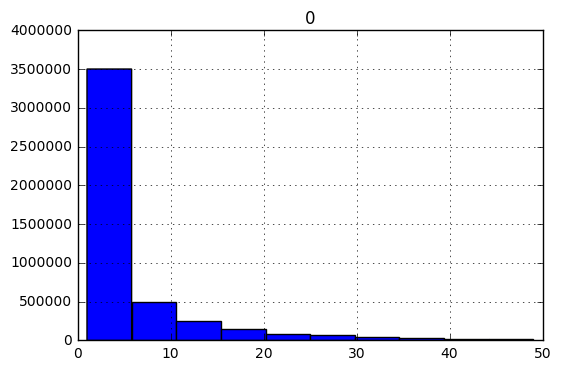

In [28]:
pd.DataFrame([len(v) for k, v in seq_user_dic.items() if len(v) < 50]).hist()

In [11]:
len(seq_user_dic)

2167019

In [10]:
%%time
for seq, users in seq_user_dic.items():
    if len(users) > 1:
        del seq_user_dic[seq]

CPU times: user 22.8 s, sys: 184 ms, total: 23 s
Wall time: 23 s


In [9]:
len([[k, v] for k, v in seq_user_dic.items() if len(v) ==1])

2167019

In [18]:
len([[k, v] for k, v in seq_user_dic.items() if len(v) ==1])

2672708

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f921ee56550>]], dtype=object)

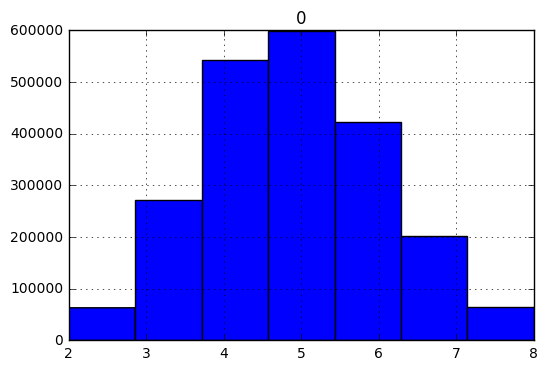

In [12]:
pd.DataFrame([len(k) for k, v in seq_user_dic.items()]).hist(bins=7)

In [15]:
%%time
seq_id_weight_dic = {}
seqid = 0
for seq, users in seq_user_dic.items():
    seq_id_weight_dic[seq] = {"id": seqid, "w": math.log(sum(users.values())) * math.log(len(seq))}
    seqid += 1

CPU times: user 46.6 s, sys: 236 ms, total: 46.8 s
Wall time: 46.7 s


In [16]:
seq_id_weight_dic

{('1114', '1690', '1691', '1114', '1692', '8020'): {'id': 0,
  'w': 1.968448971231391},
 ('51', '3957', '21', '22', '13429'): {'id': 1, 'w': 2.2311547025799614},
 ('183', '303', '178', '183', '183', '183'): {'id': 2, 'w': 3.210401995568401},
 ('6662', '6662', '6662', '7'): {'id': 3, 'w': 2.4839060486740205},
 ('3400', '3399', '3388'): {'id': 1057583, 'w': 1.7681482684484517},
 ('178', '10', '178', '1217', '178'): {'id': 1057584, 'w': 2.5902903939802346},
 ('27', '28585', '125', '19236', '125'): {'id': 4, 'w': 1.7681482684484517},
 ('224', '51', '51', '405'): {'id': 688530, 'w': 1.523000020837618},
 ('31832', '85', '10'): {'id': 17, 'w': 1.206948960812582},
 ('125', '7150', '21', '22', '27', '27', '224'): {'id': 5,
  'w': 4.046406400322019},
 ('625', '612', '7900', '7900'): {'id': 1709792, 'w': 1.9218120556728056},
 ('274', '22', '274', '51', '2256', '22'): {'id': 6, 'w': 1.968448971231391},
 ('793', '14568', '14623', '22', '793', '795'): {'id': 7,
  'w': 1.968448971231391},
 ('3037', '

In [13]:
seq_user_dic[('4173', '85', '85')]

{70: 1, 565: 1, 623: 5}

In [17]:
%%time
# Save generated seq_id_weight_dic
with open("seq_id_weight_dic_new.pkl", 'wb') as pkl:
    pickle.dump(seq_id_weight_dic, pkl)

CPU times: user 2min 41s, sys: 3.19 s, total: 2min 44s
Wall time: 2min 44s


### Load seq_id_weight_dic instead of generating

In [4]:
%%time
# Load seq_id_weight_dic instead of generating
with open("seq_id_weight_dic.pkl", 'rb') as pkl:
    seq_id_weight_dic = pickle.load(pkl)

CPU times: user 2min 43s, sys: 6.51 s, total: 2min 49s
Wall time: 2min 49s


In [5]:
len(seq_id_weight_dic)

4724421